In [14]:
import re
import os
import pandas as pd
import numpy as np
import json
import tldextract
import textcleaner as tc
import tqdm.notebook as tq
import pprint 
import datefinder
import datetime
import string
from dateutil.parser import parse

from nltk.corpus import stopwords
from stop_words import get_stop_words
from textblob.classifiers import NaiveBayesClassifier
from textblob import TextBlob

import nltk
from nltk import ngrams
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import PorterStemmer

import spacy
import en_core_web_lg
nlp = en_core_web_lg.load()

<h1>Load Data</h1>

In [2]:
ref = pd.read_csv('C:/Users/Abhinav/NLP/Baseline/ref/2019-01-01-2019-12-31-India-South_Africa.csv', sep=',')

In [3]:
X_train = {}
X_test = {}

with open('C:/Users/Abhinav/NLP/Baseline/data/project3_train.json', 'r',encoding='utf-8') as fw:
    X_train = json.load(fw)

with open('C:/Users/Abhinav/NLP/Baseline/data/project3_test.json', 'r',encoding='utf-8') as ft:
    X_test = json.load(ft)

<h1>Exploratory Data Analysis</h1>

In [4]:
ref.columns

Index(['data_id', 'iso', 'event_id_cnty', 'event_id_no_cnty', 'event_date',
       'year', 'time_precision', 'event_type', 'sub_event_type', 'actor1',
       'assoc_actor_1', 'inter1', 'actor2', 'assoc_actor_2', 'inter2',
       'interaction', 'region', 'country', 'admin1', 'admin2', 'admin3',
       'location', 'latitude', 'longitude', 'geo_precision', 'source',
       'source_scale', 'notes', 'fatalities', 'timestamp', 'iso3'],
      dtype='object')

In [5]:
print("Train data:", len(X_train))
print("Test data:", len(X_test))

Train data: 3281
Test data: 821


<h1>Data Cleaning</h1>

### Replace String "data_id" with int data

In [6]:
for i in range(len(X_train)):
    X_train[i]['data_id'] = int(X_train[i]['data_id'])
    
for i in range(len(X_test)):
    X_test[i]['data_id'] = int(X_test[i]['data_id'])

### Find missing data & Replace

In [7]:
st_x = list(ref['data_id'])

# Missing Data in X_train
print("Data Missing in Original Acled data, X_train")
for i in range(len(X_train)):
    if X_train[i]['data_id'] not in st_x:
        print(X_train[i]['data_id'],type(X_train[i]['data_id']))
print(None)

# Missing Data in X_test
print("Data Missing in Original Acled data, X_test")
for i in range(len(X_test)):
    if X_test[i]['data_id'] not in st_x:
        print(X_test[i]['data_id'],type(X_test[i]['data_id']))
print(None)

Data Missing in Original Acled data, X_train
None
Data Missing in Original Acled data, X_test
None


### De-Duplication

In [8]:
# X_train

duplicates = []
non_duplicates = []
for i in range(len(X_train)):
    current_id = X_train[i]['data_id']
    if current_id in non_duplicates:
        duplicates.append(current_id)
    else:
        non_duplicates.append(current_id)
print(len(duplicates))

487


In [9]:
# X_train

t_duplicates = []
t_non_duplicates = []
for i in range(len(X_test)):
    current_id = X_test[i]['data_id']
    if current_id in t_non_duplicates:
        t_duplicates.append(current_id)
    else:
        t_non_duplicates.append(current_id)
print(len(t_duplicates))

38


In [10]:
dump = []
seen = []
for block in X_train:
    if block['data_id'] not in seen:
        dump.append(block)
        seen.append(block['data_id'])
X_train = dump

In [11]:
dump2 = []
seen = []
for block in X_test:
    if block['data_id'] not in seen:
        dump2.append(block)
        seen.append(block['data_id'])
X_test = dump2

In [12]:
print("Train data:", len(X_train))
print("Test data:", len(X_test))

Train data: 2794
Test data: 783


In [13]:
type(X_train[0]['data_id'])

int

In [16]:
X_train[0]

{'id': 402,
 'data_id': 5598909,
 'country': 'India',
 'source_url': 'https://www.thehindu.com/news/cities/Madurai/tnstc-staff-pensioners-stage-protest/article17529330.ece',
 'source_name': 'The Hindu',
 'published_date': '02-19-2019',
 'headline': 'TNSTC staff, pensioners stage protest',
 'content': 'The police arrested 234 employees and retired workers of Tamil Nadu State Transport Corporation when they staged a dharna in front of depots at seven places in the district on Saturday.  As TNSTC struggles to disburse pension on the first day of every month, settle retirement benefits and revised salary as per the wage settlement negotiations, workers and retired employees are staging various protests.  When they staged a dharna in front of depots on Saturday to prevent buses being taken out to various destinations, the police arrested them. The agitation began at 3.30 a.m. at Vannarpet.  The protests were organised at Vannarpet (80), Bypass Road depot (34), KTC Nagar depot (46), Shencott

<h1>Populate labels for Train & Test data</h1>


In [ ]:
labels = dict()
for i in tq.tqdm(range(len(ref))):
    d_id = int(ref.iloc[i].data_id)
    labels[d_id] = dict()
    dt = parse(str(ref.iloc[i].event_date))
    labels[d_id]["event_date"] =  str(dt.strftime('%m-%d-%Y'))  # Event-date 
    
    labels[d_id]["location"] = ref.iloc[i].location               # Location
    
    labels[d_id]["event_type"] = ref.iloc[i].event_type           # Event-type
    labels[d_id]["sub_event_type"] = ref.iloc[i].sub_event_type   # Sub Event-type
    
    
    actrs = []
    actr1 = ref.iloc[i].actor1
    assoc_actr_1 = ref.iloc[i].assoc_actor_1
    actr2 = ref.iloc[i].actor2
    assoc_actr_2 = ref.iloc[i].assoc_actor_2

    if actr1 and not pd.isna(actr1):
        labels[d_id]["actor1"] = actr1.split(";")
    else:
        labels[d_id]["actor1"] = "N/A"
        
    if assoc_actr_1 and not pd.isna(assoc_actr_1):
        labels[d_id]["assoc_actor_1"] = assoc_actr_1.split(";")
    else:
        labels[d_id]["assoc_actor_1"] = "N/A"
        
    if actr2 and not pd.isna(actr2):
        labels[d_id]["actor2"] = actr2.split(";")
    else:
        labels[d_id]["actor2"] = "N/A"
        
    if assoc_actr_2 and not pd.isna(assoc_actr_2):
        labels[d_id]["assoc_actor_2"] = assoc_actr_2.split(";")
    else:
        labels[d_id]["assoc_actor_2"] = "N/A"
    
                                                        # Sources - Ignored
    labels[d_id]["parties_involved"] = actrs            # Parties involved
    labels[d_id]["notes"] = ref.iloc[i].notes           # Description

In [807]:
with open('C:/Users/Abhinav/NLP/Baseline/labels/project_labels.json', 'w',encoding='utf-8') as fq:
    json.dump(labels,fq)

In [22]:
labels = dict()
with open('C:/Users/Abhinav/NLP/Baseline/labels/project_labels.json', 'r',encoding='utf-8') as fq:
    labels = json.load(fq)

<h1>Pre-processing</h1>

In [15]:
#**************************************************Getters**************************************************************#

default_stopwords = list(get_stop_words('en'))         #About 900 stopwords
nltk_words = list(stopwords.words('english'))       #About 150 stopwords
default_stopwords.extend(nltk_words)

def get_clean_text(raw_text):
    
    def tokenize_text(text):
        return [w for s in sent_tokenize(text) for w in word_tokenize(s)]
    
    def remove_stopwords(text, stop_words=default_stopwords):
        tokens = [w for w in tokenize_text(text) if w not in stop_words]
        return ' '.join(tokens)
    
    # Remove line breaks and carriage returns
    text = raw_text.replace('\r', ' ').replace('\n', ' ') 
    # strip whitespaces
    text = text.strip(' ') 
    # lowercase
#     text = text.lower() 
    # remove punctuation and symbols
    text = text.replace('+', ' ').replace(':', ' ').replace('@',' ').replace('$',' ')
    text = text.replace('#', ' ').replace('%', ' ').replace('^', ' ').replace('&',' ').replace('“',' ')
    text = text.replace('”',' ').replace('*',' ').replace('<',' ').replace('>',' ').replace('!',' ')
#     text = remove_stopwords(text)              # remove stopwords
    clean_token = word_tokenize(text)
    return text, clean_token
    
def get_StanfordNER_text(clean_text):
    
    root_path = "C:/Users/Abhinav/NLP/Baseline/"
    classifier = "english.muc.7class.distsim.crf.ser.gz"
    
    st = StanfordNERTagger(root_path+'Resources/stanford-ner-2018-10-16/classifiers/'+classifier,
                           root_path+'Resources/stanford-ner-2018-10-16/stanford-ner-3.9.2.jar',
                           encoding='utf-8')
    
    return st.tag(clean_text)

def get_SpacyNER_text(clean_text):
    
    text = nlp(" ".join(clean_text))
    tag_set = set([(X.text, X.label_) for X in text.ents])
    
    return list(tag_set)

def get_POS_text(sentence):
    sentence = nltk.word_tokenize(sentence)
    sentence = nltk.pos_tag(sentence)
    return sentence
    
def get_continuous_chunks(tagged_sent):  #Inside, Outside, Beginning (IOB)
    
    continuous_chunk = []
    current_chunk = []
    
    for token, tag in tagged_sent:
        if tag != "O":
            current_chunk.append((token, tag))
        else:
            if current_chunk:                       # if the current chunk is not empty
                continuous_chunk.append(current_chunk)
                current_chunk = []
                
    if current_chunk:
        continuous_chunk.append(current_chunk)
    return continuous_chunk

def get_sentences(raw_text):
    return sent_tokenize(raw_text)

def get_matching_sentences(raw_text,entities):
    sentences_with_word = []
    sentences_list = get_sentences(raw_text)
    for word in entities:
        for sentence in sentences_list:
            if sentence.count(word)>0:
                sentences_with_word.append(sentence)
    return sentences_with_word

def get_ngrams(text, n ):
 
    def tokenize_text(text):
        return [w for s in sent_tokenize(text) for w in word_tokenize(s)]
    
    def remove_stopwords(text, stop_words=default_stopwords):
        tokens = [w for w in tokenize_text(text) if w not in stop_words]
        return ' '.join(tokens)

    text = text.replace('\r', ' ').replace('\n', ' ') 
    text = text.lower() 
    text = text.replace('+', ' ').replace(':', ' ').replace('@',' ').replace('$',' ').replace('.','')
    text = text.replace('#', ' ').replace('%', ' ').replace('^', ' ').replace('&',' ').replace('“',' ')
    text = text.replace('”',' ').replace('*',' ').replace('<',' ').replace('>',' ').replace('!',' ')
    text = text.strip(' ')
    text = remove_stopwords(text)
    
    n_grams = ngrams(word_tokenize(text), n)
    
    return [ ' '.join(grams) for grams in n_grams]

## Entity based methods - Actors

In [16]:
#*************************************************Filters**************************************************************#

def PERSON(data):   # Actors - Persons
    persons = set()    
    for i in range(0,len(data)):
        if data[i][1] == "PERSON":
            persons.add(data[i][0])
    return list(persons)

def ORGANIZATION(data):  # Actors - Organizations/Nationalities/religious/political groups
    organizations = set()
    for i in range(0,len(data)):
        if data[i][1] == "ORGANIZATION":
            organizations.add(data[i][0])
    return list(organizations)

## Gazetteer based methods - Location

© Government of India Open Data License and Government of South Africa Data Catalog

In [17]:
import unicodedata

in_geonames = []
in_geo = pd.read_csv("C:/Users/Abhinav/NLP/Baseline/gazetteer/GeoNames/IN.txt", dtype='unicode', header=None, sep='\t', low_memory=False)
dump = list(in_geo[1])

for i in dump:
    bit = unicodedata.normalize('NFKD', i).encode('ascii','ignore')
    bit = str(bit,'utf-8')
    in_geonames.append(bit.lower())

del dump

sa_geonames = []
dump2 = []

with open('C:/Users/Abhinav/NLP/Baseline/gazetteer/GeoNames/SA.json', 'r',encoding='utf-8') as fx:
    dump2 = json.load(fx)

for i in dump2:
    sa_geonames.append(i['City'])

del dump2

In [18]:
len(in_geonames)

648831

In [15]:
len(sa_geonames)

12675

In [19]:
def LOCATION(tags, text, KB, heuristic): # Locations - Geocoded
    loc = set()
    
    # Locations from NER
    for i in range(0,len(tags)):
        if tags[i][1] == "LOCATION":
            if tags[i][0].lower() in KB:
                loc.add(tags[i][0].lower())
    
    # Locations from Knowledge Base(KB)
    sentences = get_sentences(text)
    sentences = sentences[0:heuristic]
    
    for sentence in sentences:
        for i in range(1,4):
            grams = get_ngrams(sentence,i)
            for gram in grams:
                if gram in KB:
                    loc.add(gram)
    return list(loc)

## Context based methods - Date

In [20]:
def DATE(raw_text,published_date):   # Temporal Date - Event date (handles Heterogeneous cases and locality)
    
    def nearest(items, pivot):
        nearest = [i for i in items if i <= pivot]
        if nearest:
            return min(nearest, key=lambda x: abs(x - pivot))
        else:
            return pivot
        
    def isValidDate(items,pub):
        rt = []
        for item in items:
            try:
                x=datetime.datetime.strptime(item,'%m-%d-%Y')
                rt.append(item)
            except:
#                 day = int(item[3:5]) - 2
#                 y = item[0:2]+"-"+str(day)+"-"+item[6:10]
                rt.append(pub)
        return rt
                
    m = {
        '1': "01",
        '2': "02",
        '3': "03",
        '4':"04",
         '5':"05",
         '6':"06",
         '7':"07",
         '8':"08",
         '9':"09",
         '10':"10",
         '11':"11",
         '12':"12",
         '01': "01",
         '02': "02",
         '03': "03",
         '04':"04",
         '05':"05",
         '06':"06",
         '07':"07",
         '08':"08",
         '09':"09",
        }
    
    d = {'1': "01",'2': "02",'3': "03",'4': "04",'5': "05",'6': "06",'7':"07",'8':"08",'9':"09",'10':"10",
             '11':"11", '12':"12",'13':"13",'14':"14",'15':"15",'16':"16",'17':"17",'18':"18",'19':"19",'20':"20",
             '21':"21",'22':"22",'23':"23",'24':"24",'25':"25",'26':"26",'27':"27",'28':"28",'29':"29",'30':"30",'31':"31",
             '01': "01",'02': "02",'03': "03",'04':"04",'05':"05",'06':"06",'07':"07",'08':"08",'09':"09"}
    
    # Convert Published date to MM-DD-YYYY 
    if published_date and published_date != "NA" and published_date != "N/A" and  (not pd.isna(published_date)):
        pub = list( datefinder.find_dates(str(published_date)) )
        pub_date = m[str(pub[0].month)]+"-"+d[str(pub[0].day)]+"-"+"2019"
    else:
        pub_date = "12-30-2019"
    
    sentences = get_sentences(raw_text)      # MM-DD-YYYY
    dates_list = []
    date = ""
    
    for sentence in sentences:
        try:
            matches = list(datefinder.find_dates(sentence))
            if matches:
                for match in matches:
                    if str(match.year) == "2020" or str(match.year) == "2019":         
                        dates_list.append(m[str(match.month)]+"-"+d[str(match.day)]+"-"+str(2019))
        except:
            continue
                    
#     print(dates_list)   
    rt_dates = isValidDate(dates_list,pub_date)
#     print(rt_dates)
    
    time_stamps = [datetime.datetime.strptime(each_date, "%m-%d-%Y").date() for each_date in rt_dates]
    base = datetime.datetime.strptime(pub_date, "%m-%d-%Y").date()

    if time_stamps:
        possible_date = nearest(time_stamps,base)
        return m[str(possible_date.month)]+"-"+d[str(possible_date.day)]+"-"+str(2019),1
    else:
        possible_date = base
        return m[str(possible_date.month)]+"-"+d[str(possible_date.day)]+"-"+str(2019),0


## Model based methods - Event type

In [23]:
train = []

for i in range(len(X_train)):
    did = X_train[i]['data_id']
    x = (labels[str(did)]['notes'],labels[str(did)]['event_type'])
    train.append(x)

In [24]:
test = []
for i in range(len(X_test)):
    did = X_test[i]['data_id']
    x = (labels[str(did)]['notes'],labels[str(did)]['event_type'])
    test.append(x)

In [25]:
cl = NaiveBayesClassifier(train)

In [26]:
print(cl.classify("09 March. The R300, Cape Town, has been closed by protesters with burning tyres. Police was on the scene. [size=50]."))

Protests


In [ ]:
#************************************#

In [28]:
from sklearn import model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import string
from sklearn.neighbors import KNeighborsClassifier

In [60]:
diff_subevent = []

for i in range(len(X_train)):
    did = int(X_train[i]['data_id'])
    if labels[str(did)]['sub_event_type'] not in diff_subevent:
        diff_subevent.append(labels[str(did)]['sub_event_type'])
        
print(diff_subevent)

['Peaceful protest', 'Protest with intervention', 'Mob violence', 'Violent demonstration', 'Excessive force against protesters']


In [622]:
subevent_map = {'Excessive force against protesters': 0, 'Mob violence': 1, 'Violent demonstration': 2, 'Protest with intervention': 3, 'Peaceful protest': 4}

In [742]:
dataset = X_train   # SET repo HERE

texts = []
ev_label = []
se_label = []

for i in range(len(dataset)):
    texts.append(dataset[i]['content'])
    uid = int(dataset[i]['data_id'])
    ev_label.append(labels[uid]['event_type'])
    se_label.append(labels[uid]['sub_event_type'])

In [33]:
def knn(all_text,all_label):
    sentences_train, sentences_test, y_train, y_test = model_selection.train_test_split(all_text, all_label, test_size=0.33, random_state=42)
    filename = 'Resources/TFIDF_Vector.pickle'
    tfidf_vect_ngram = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2), stop_words='english')
    tfidf_vect_ngram.fit(all_text)
    pickle.dump(tfidf_vect_ngram, open(filename, "wb"))
    X_train =  tfidf_vect_ngram.transform(sentences_train)
    X_test =  tfidf_vect_ngram.transform(sentences_test)
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)
    return knn,X_test,y_test,tfidf_vect_ngram

In [743]:
event_knn, X_e, y_e, tfidf_vect_e = knn(texts,ev_label)
subevent_knn, X_se, y_se, tfidf_vect_se = knn(texts,se_label)

<h3>Extraction</h3>

#### Don't run this cell repeatedly - may timeout 

(Window: 120 min)

(Execution time: 40 hrs)

In [ ]:
FINAL_DATA = dict()

source = X_test

for i in tq.tqdm(range(len(source))):
    
    clean_text, clean_token = get_clean_text(source[i]['content'])
    NE_stanford = get_StanfordNER_text(clean_token)
    chunks_stanford = get_continuous_chunks(NE_stanford)
    NE_group_stanford = [(" ".join([token for token, tag in ne]), ne[0][1]) for ne in chunks_stanford]
    
    date,found = DATE(clean_text, source[i]['published_date'])
    
    if source[i]['country'] == "India":
        know = in_geonames
    else:
        know = sa_geonames
    
    loc = LOCATION(tags = NE_group_stanford, text = clean_text, KB = know, heuristic = 4)
    persons = PERSON(NE_group_stanford)
    org = ORGANIZATION(NE_group_stanford)
    
    inp=[clean_text]
    
    trans_event = tfidf_vect_e.transform(inp)
    output_event = event_knn.predict(trans_event)
    trans_subevent = tfidf_vect_se.transform(inp)
    output_subevent = subevent_knn.predict(trans_subevent)
    output_actor = cl.classify(clean_text)
    
    d_id = source[i]['data_id']
    FINAL_DATA[d_id] = dict()
    
    FINAL_DATA[d_id]["event_date"] = date
    FINAL_DATA[d_id]["date_found"] = found
    FINAL_DATA[d_id]["location"] = loc
    FINAL_DATA[d_id]["event_type"] = str(output_event[0])
    FINAL_DATA[d_id]["sub_event_type"] = str(output_subevent[0])
    FINAL_DATA[d_id]["actors_involved"] = output_actor
    FINAL_DATA[d_id]["persons_involved"] = persons
    FINAL_DATA[d_id]["org_involved"] = org
    FINAL_DATA[d_id]["data_source"] = source[i]['source_name']

In [808]:
# Slots only
with open('C:/Users/Abhinav/NLP/Baseline/FINAL/teamcrawlers_test_data.json', 'w',encoding='utf-8') as ft:
    json.dump(FINAL_DATA,ft)

# /* END of Slot Filling */

In [46]:
from geopy.geocoders import Nominatim
from sklearn.metrics import classification_report

In [35]:
ref = pd.read_csv('C:/Users/Abhinav/NLP/Baseline/ref/2019-01-01-2019-12-31-India-South_Africa.csv', sep=',')

india = []
sa = []

for i in range(len(ref)):
    if ref.iloc[i]['country'] == 'India':
        india.append(str(ref.iloc[i]['data_id']))
    if ref.iloc[i]['country'] == 'South Africa':
        sa.append(str(ref.iloc[i]['data_id']))

In [36]:
labels = dict()
with open('C:/Users/Abhinav/NLP/Baseline/labels/project_labels.json', 'r',encoding='utf-8') as fq:
    labels = json.load(fq)

In [37]:
dump_train1 = dict()
with open('C:/Users/Abhinav/NLP/Baseline/events/teamcrawlers_train_data1.json', 'r',encoding='utf-8') as fq:
    dump_train1 = json.load(fq)

dump_train2 = dict()
with open('C:/Users/Abhinav/NLP/Baseline/events/teamcrawlers_train_data2.json', 'r',encoding='utf-8') as fq2:
    dump_train2 = json.load(fq2)

dump_train = {**dump_train1, **dump_train2}



dump_test = dict()
with open('C:/Users/Abhinav/NLP/Baseline/events/teamcrawlers_test_data.json', 'r',encoding='utf-8') as fq2:
    dump_test = json.load(fq2)

# SET Dataset HERE
slots = dump_train

num_records = len(slots)

In [58]:
dump_summary_train1 = dict()
dump_summary_train2 = dict()
summary_test = dict()

with open('temp/project3_train_output-0-1000.json', 'r',encoding='utf-8') as fq:
    dump_summary_train1 = json.load(fq)

with open('temp/project3_train_output-1001-2794.json', 'r',encoding='utf-8') as fq:
    dump_summary_train2 = json.load(fq)

summary_train = {**dump_summary_train1, **dump_summary_train2}          
          
with open('temp/project3_test_output-all.json', 'r',encoding='utf-8') as fq2:
    summary_test = json.load(fq2)

In [39]:
#********************************************#

In [ ]:
FM = 0
NFNM = 0
FNM = 0
NFM = 0

for i in ids:
    actual = labels[i]['event_date']
    predicted = slots[i]['event_date']
    if slots[i]['date_found'] == 1 and actual == predicted :              # Found + match
        FM+=1
    elif slots[i]['date_found'] == 0 and actual != predicted :            # Not Found + No match
        NFNM+=1
    elif slots[i]['date_found'] == 1 and actual != predicted :            # Found + No match
        FNM+=1
    elif slots[i]['date_found'] == 0 and actual == predicted :            # Not Found + match
        NFM+=1
        
print("Found + match: ", FM)
print("Not Found + No match: ", NFNM)
print("Found + No match: ",FNNM )
print("Not Found + match: ", NFM)

In [41]:
#********************************************#

In [ ]:
match = 0

for i in ids:
    actual = str(labels[i]['location']).lower()
    predicted = slots[i]['location']
    
    if actual in predicted:
        match+=1
print(match)

In [47]:
#********************************************#

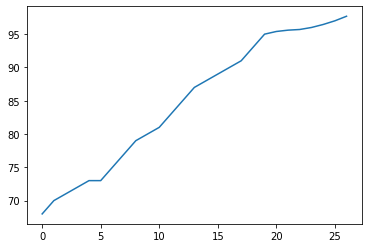

In [45]:
# Event type
predicted = []
actual = []

for i in ids:
    predicted.append(slots[i]['event_type'])

for i in ids:
    actual.append(labels[i]['event_type'])

print(classification_report(actual,predicted))

In [48]:
#********************************************#

In [ ]:
# Sub-event
predicted = []
actual = []

for i in ids:
    predicted.append(slots[i]['actors_involved'])

for i in ids:
    actual.append(labels[i]['actor1'][0])

print(classification_report(actual,predicted))

In [49]:
#********************************************#

In [ ]:
match =0
for i in ids:
    
    parties = []
    
    if labels[i]['actor1'] != "N/A":
        a1 = labels[i]['actor1']
    else:
        a1 = []
    
    if labels[i]['assoc_actor_1'] != "N/A":
        aa1 = labels[i]['assoc_actor_1']
    else:
        aa1 = []
    
    if labels[i]['actor2'] != "N/A":
        a2 = labels[i]['actor2']
    else:
        a2 = []
    
    if labels[i]['assoc_actor_2'] != "N/A":
        aa2 = labels[i]['assoc_actor_2']
    else:
        aa2 = []
            
    parties = a1+aa1+a2+aa2
            
    for party in parties:
        if party in slots[i]['org_involved'] or party in slots[i]['persons_involved']:
            match+=1
    
print(match)

In [50]:
#********************************************#

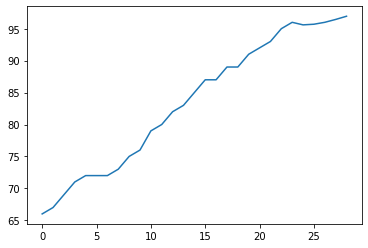

In [51]:
# Actors
predicted = []
actual = []

for i in ids:
    predicted.append(slots[i]['actors_involved'])

for i in ids:
    actual.append(labels[i]['actor1'][0])

print(classification_report(actual,predicted))

In [52]:
from datetime import datetime

def get_date(inp):
    date = datetime.strptime(inp, "%m-%d-%Y")
    return datetime.strftime(date, "%Y-%m-%dT%H:%M:%SZ")

In [59]:
indexer_dump = {**dump_train, **dump_test}
indexer_summary = {**summary_train, **summary_test}

In [ ]:
FINAL = []
summary_file = indexer_summary
slots = indexer_dump
ids = slots.keys()
geolocator = Nominatim(user_agent="Testapp")

for i in tq.tqdm(ids):
    _d = dict()
    print(i)
    _d['data_id'] = i
    _d['actors_involved'] = slots[i]['actors_involved']
    _d['data_source'] = slots[i]['data_source']
    _d['data_source'] = slots[i]['data_source']
    _d['date_found'] = slots[i]['date_found'] 
    _d['event_date'] = get_date(slots[i]['event_date'])
    _d['event_type'] = slots[i]['event_type']
    _d['sub_event_type'] = slots[i]['sub_event_type']
    
    actual = str(labels[i]['location']).lower()
    if actual in slots[i]['location']:
        to_loc = actual
    else:
        if slots[i]['location']:
            to_loc = slots[i]['location'][0]
        else:
            to_loc = actual
    
    _d['location'] = to_loc

    if i in india:
        cntry = 'India'
    if i in sa:
        cntry = 'South Africa'
    
    _d['country'] = cntry

    coordinates = geolocator.geocode(to_loc+", "+cntry)
    
    if coordinates:
        _d['latitude'] = coordinates.latitude
        _d['longitude'] = coordinates.longitude
    else:
        cd = geolocator.geocode(cntry)
        _d['latitude'] = cd.latitude
        _d['longitude'] = cd.longitude
        
    _d['org_involved'] = slots[i]['org_involved']
    _d['persons_involved'] = slots[i]['persons_involved']
    _d['summary'] = summary_file[i]['summary']
    FINAL.append(_d)

In [ ]:
with open('FINAL/index.json', 'w',encoding='utf-8') as ff:
    json.dump(FINAL,ff)

# /* END */